In [431]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # for making figures
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
from timeit import default_timer as timer  #for checking run time
from datetime import timedelta
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import callbacks
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization
from keras import models
from keras import layers

In [432]:
df = pd.read_csv("The-Office-Lines-V2.csv")
print(f"dataset has {df.columns.shape[0]} columns \ndataset has {df.shape[0]} rows")
df.head(3)

dataset has 6 columns 
dataset has 54167 rows


,season,episode,title,scene,speaker,line
0,1,1,Pilot,1,Michael,All right Jim. Your quarterlies look very good...
1,1,1,Pilot,1,Jim,"Oh, I told you. I couldn't close it. So..."
2,1,1,Pilot,1,Michael,So you've come to the master for guidance? Is ...


In [433]:
df.isnull().sum()  #no missing value

season     0
episode    0
title      0
scene      0
speaker    0
line       0
dtype: int64

In [434]:
df.dtypes # we have 3 integer/numeric and 3 object columns

season      int64
episode     int64
title      object
scene       int64
speaker    object
line       object
dtype: object

In [435]:
dicct ={}
for i in range(5):
    dicct[df.iloc[:,i].name] = df.iloc[:,i].unique()
dicct.keys()

dict_keys(['season', 'episode', 'title', 'scene', 'speaker'])

In [436]:
len(dicct["speaker"])

777

In [463]:
mostchar=df.groupby(by="speaker",sort=False).agg({"speaker":"count"}).rename_axis("index").sort_values(by="speaker",ascending=False)[:10].index
mostchar.tolist()

['Michael',
 'Dwight',
 'Jim',
 'Pam',
 'Andy',
 'Angela',
 'Kevin',
 'Erin',
 'Oscar',
 'Ryan']

In [464]:
df2=df[df.speaker.isin(mostchar)]

In [662]:
bım=lambda x:len(x.split())
df2["line"].apply(bım).sort_values(ascending =False).head()  #length of lines

13117    232
3385     164
34647    163
12191    159
24275    157
Name: line, dtype: int64

In [465]:
x1 = df2.line
x1
y1 = df2.speaker
y1

0        Michael
1            Jim
2        Michael
3            Jim
4        Michael
          ...   
54157      Kevin
54158      Oscar
54160       Erin
54165        Jim
54166        Pam
Name: speaker, Length: 39113, dtype: object

In [466]:
X_train, X_test, y_train, y_test = train_test_split(x1, y1, test_size=0.3,random_state=42)

In [652]:
class sentimentanalysis(object):
    
    def fit_str(self,stringg:str):   #In the end i have learned that column vectorizer figures this one out but for using strict this needed
        stringg = stringg.lower() 
        self.arr= np.array(" ".join(re.split("\s+", stringg, flags=re.UNICODE)).split())
        return self.arr
    
    def fit_array(self,array:np.array): #this also not very necessary, at least last part is called at Predict
        length = array.size
        for a in range(length):
            array[a] = array[a].lower()
            array[a] =" ".join(re.split("\s+", array[a], flags=re.UNICODE))
        array = self.cv.transform(array)
        return array
    
    def processDataFrame(self,data,label1:str,label2:str): # If you want to train model and you only have a dataframe
        

        data2=data.copy()
        data2[label1+" processed"] =data2[label1].apply(lambda x: " ".join(self.fit_str(x)))
        self.data2 = data2
        self.label1 = label1
        self.label2 = label2
        self.x=np.array(self.data2[self.label1])
        self.y=np.array(self.data2[self.label2])
        
    def model_train_test_build(self,y = None,x=None): #if you have x and y just use this one
        if x is None:
            x = self.x
        else:
            x = x
        if y is None:
            y = self.y
        else:
            y  = y
            
        self.cv = CountVectorizer()
        self.clf = MultinomialNB()
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3 )
        X_train =self.cv.fit_transform(X_train)
        X_test = self.cv.transform(X_test)
        self.clf.fit(X_train,y_train)
        pred = self.clf.predict(X_test)
        if np.unique(y).size == 2:
            
            self.matrix=confusion_matrix(y_test,pred)
            sns.set(font_scale=1.5)
            fig, ax = plt.subplots(figsize=(3, 3))
            ax = sns.heatmap(self.matrix,
                     annot=True,
                     cbar=False)
            plt.xlabel("Predicted label")
            plt.ylabel("True label")
        print("Accuracy : ",sum(pred==y_test)/y_test.size)
        
    def Predict(self,inp=None):  #After all steps use this, you may just give an string or a array of strings
    
        if inp is None:
            inp = str(input())

        
        if type(inp) == str:
            inp = np.array([" ".join((self.fit_str(inp)))])
            inp = self.cv.transform(inp)
            return self.clf.predict(inp)
        elif type(inp)==np.ndarray:
            inp  = self.fit_array(inp)
            return self.clf.predict(inp)
        else:
            print("Please give array or string")

In [653]:
dtc = sentimentanalysis()

In [654]:
dtc.processDataFrame(df2,"line","speaker")

dtc.model_train_test_build()


Accuracy :  0.31881711266405316


In [655]:
np.unique(y1.values,return_counts=True)

(array(['Andy', 'Angela', 'Dwight', 'Erin', 'Jim', 'Kevin', 'Michael',
        'Oscar', 'Pam', 'Ryan'], dtype=object),
 array([ 3658,  1529,  6707,  1401,  6156,  1516, 10712,  1320,  4933,
         1181], dtype=int64))

In [656]:
sum(dtc.Predict(x1.values) == y1.values)/y1.values.size

0.4008897297573697

In [657]:
data=np.unique(dtc.Predict(x1.values),return_counts=True)

In [596]:
dff=pd.DataFrame(data).T
dff=dff.set_index(0).rename_axis("index").rename(columns={1:"model's"})
dfforiginal=df.groupby(by="speaker",sort=False).agg({"speaker":"count"}).rename_axis("index").sort_values(by="speaker",ascending=False)[:10]

In [598]:
df_merged= dfforiginal.join(dff).rename(columns={"speaker":"original"}).reset_index()
df_merged
#here comes to melting
df_last = df_merged.melt(id_vars=["index"],var_name="original_or_model",value_name="line_count")
df_last.head(5)

,index,original_or_model,line_count
0,Michael,original,10712
1,Dwight,original,6707
2,Jim,original,6156
3,Pam,original,4933
4,Andy,original,3658


Text(0, 0.5, 'Log Count of Line')

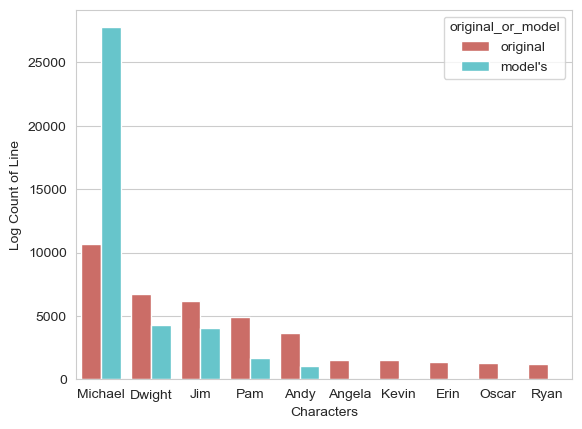

In [627]:
sns.set_style('whitegrid')
plott=sns.barplot(x='index', y='line_count', hue='original_or_model', data=df_last, palette='hls')
#plott.set(yscale="log")

#plt.title('Time Spent by Individuals in Different Activities')
plt.xlabel('Characters')
plt.ylabel('Log Count of Line')

In [660]:

aa=int(input())
print(df2.speaker[aa])
print(dtc.x[aa])


731
Jim
i just thought it was kind of a flat, you know... 25 dollar, one-time donation. i didn't think it was per mile kinda deal. you know, so...


In [661]:
dtc.Predict(dtc.x[aa])

array(['Jim'], dtype='<U7')

In [482]:
X3 = df2.line
X3
y3 = df2.speaker
y3
labels=y3.unique().tolist()
labels2 = {i[1]:i[0] for i in enumerate(labels)}
labels2
y_labels_all=df2.replace(labels2)["speaker"]
y_labels_all
i_label = {value:key for key,value in labels2.items()}
i_label

{0: 'Michael',
 1: 'Jim',
 2: 'Pam',
 3: 'Dwight',
 4: 'Oscar',
 5: 'Angela',
 6: 'Kevin',
 7: 'Ryan',
 8: 'Andy',
 9: 'Erin'}

In [483]:
lavector = CountVectorizer()
X4=lavector.fit_transform(X3)
X4.shape

(39113, 16481)

In [484]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X4, y_labels_all,stratify=y_labels_all ,test_size=0.3 )

In [485]:
X_train,X_val,y_train,y_val =train_test_split(X_train_val,y_train_val,stratify=y_train_val,test_size = 0.2)

In [486]:
Y_train = to_categorical(y_train)
Y_val = to_categorical(y_val)
Y_test = to_categorical(y_test)

In [244]:
lavector = CountVectorizer()

X_train =lavector.fit_transform(X_train)
X_val = lavector.transform(X_val)
X_test = lavector.transform(X_test)

X_train.shape

(29677, 14390)

In [487]:
X_val =X_val.astype('float32')
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [488]:
X_train.shape

(21903, 16481)

In [489]:
X_test.shape

(11734, 16481)

In [490]:
X_val.shape

(5476, 16481)

In [491]:
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape = (X_train.shape[1],),bias_initializer='ones',kernel_initializer='random_uniform'))
model.add(layers.Dense(128, activation='relu' ,bias_initializer='zeros',kernel_initializer='random_uniform'))
model.add(layers.Dense(len(i_label), activation='softmax',bias_initializer='zeros',kernel_initializer='random_uniform'))

In [492]:
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [493]:
Y_val


array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [494]:
history = model.fit(X_train,
                   Y_train,
                   epochs=100,
                   batch_size=312,
                   validation_data=(X_val, Y_val))

Epoch 1/100


C:\Users\ahmet\anaconda3\envs\new_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_16/dense_48/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_16/dense_48/embedding_lookup_sparse/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_16/dense_48/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


71/71 [==============================] - 1s 10ms/step - loss: 2.0249 - accuracy: 0.2720 - val_loss: 2.0141 - val_accuracy: 0.2739
Epoch 2/100
71/71 [==============================] - 1s 9ms/step - loss: 1.9871 - accuracy: 0.2759 - val_loss: 1.9848 - val_accuracy: 0.2783
Epoch 3/100
71/71 [==============================] - 1s 8ms/step - loss: 1.9365 - accuracy: 0.3011 - val_loss: 1.9682 - val_accuracy: 0.2821
Epoch 4/100
71/71 [==============================] - 1s 8ms/step - loss: 1.8748 - accuracy: 0.3366 - val_loss: 1.9830 - val_accuracy: 0.2849
Epoch 5/100
71/71 [==============================] - 1s 8ms/step - loss: 1.8182 - accuracy: 0.3642 - val_loss: 1.9568 - val_accuracy: 0.3055
Epoch 6/100
71/71 [==============================] - 1s 8ms/step - loss: 1.7614 - accuracy: 0.3878 - val_loss: 1.9420 - val_accuracy: 0.3115
Epoch 7/100
71/71 [==============================] - 1s 8ms/step - loss: 1.7093 - accuracy: 0.4095 - val_loss: 1.9660 - val_accuracy: 0.3104
Epoch 8/100
71/71 [=====

Epoch 59/100
71/71 [==============================] - 1s 8ms/step - loss: 0.9102 - accuracy: 0.6645 - val_loss: 3.3218 - val_accuracy: 0.2785
Epoch 60/100
71/71 [==============================] - 1s 8ms/step - loss: 0.9059 - accuracy: 0.6700 - val_loss: 3.3728 - val_accuracy: 0.2812
Epoch 61/100
71/71 [==============================] - 1s 8ms/step - loss: 0.9018 - accuracy: 0.6668 - val_loss: 3.3580 - val_accuracy: 0.2736
Epoch 62/100
71/71 [==============================] - 1s 8ms/step - loss: 0.8973 - accuracy: 0.6703 - val_loss: 3.3711 - val_accuracy: 0.2580
Epoch 63/100
71/71 [==============================] - 1s 8ms/step - loss: 0.8959 - accuracy: 0.6683 - val_loss: 3.4188 - val_accuracy: 0.2624
Epoch 64/100
71/71 [==============================] - 1s 8ms/step - loss: 0.8925 - accuracy: 0.6717 - val_loss: 3.4667 - val_accuracy: 0.2655
Epoch 65/100
71/71 [==============================] - 1s 8ms/step - loss: 0.8905 - accuracy: 0.6723 - val_loss: 3.5161 - val_accuracy: 0.2904
Epoch 

Minimum Validation Loss: 1.9420
0.7104049921035767


<AxesSubplot:>

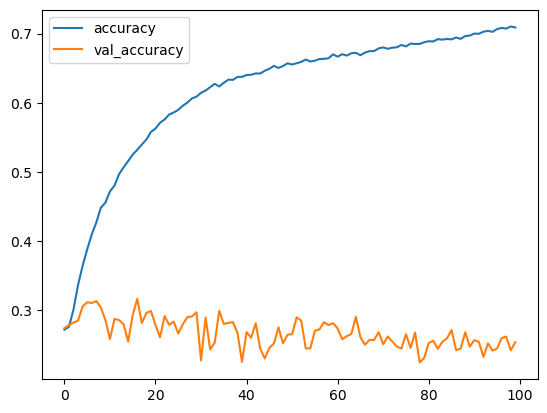

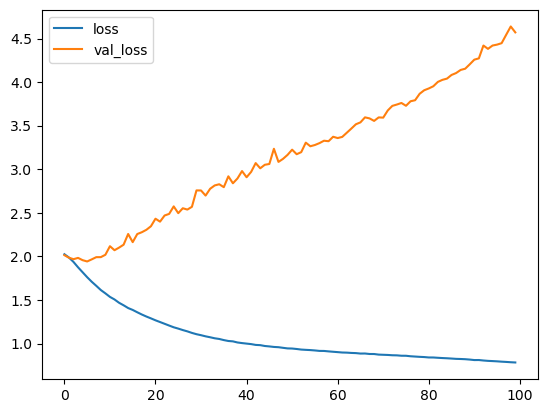

In [495]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));
print(history_df["accuracy"].max())
history_df.loc[:, ['loss', 'val_loss']].plot()

In [496]:
model.evaluate(X_test,Y_test)

367/367 [==============================] - 0s 725us/step - loss: 4.6516 - accuracy: 0.2671


[4.651595592498779, 0.26708710193634033]

In [497]:
Y_test

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [530]:
a = 28806
bım=df2.line[a]


In [531]:
bım2=lavector.transform([bım])

In [532]:
model.predict(bım2).argmax()

1/1 [==============================] - 0s 8ms/step


3

In [533]:
i_label


{0: 'Michael',
 1: 'Jim',
 2: 'Pam',
 3: 'Dwight',
 4: 'Oscar',
 5: 'Angela',
 6: 'Kevin',
 7: 'Ryan',
 8: 'Andy',
 9: 'Erin'}

In [534]:
df2.line[a]

"you know what you can keep your stupid favor. it's worthless. and this is my dinner on your face. i'm keeping it."

In [535]:
df2.speaker[a]

'Dwight'

In [401]:
bıma=model.predict(X_test).argmax(axis=1)

387/387 [==============================] - 0s 633us/step


In [402]:
sum(y_test ==  bıma)/y_test.size

0.2468057577227883